In [1]:
# TAREAS DE LOS MÓDULOS DE CNN Y RNN - MIAX9
# Para cada uno de los siguientes ejercicios entregar un fichero en ipython notebook  (.ipynb).
# En cada fichero tenéis que solucionar un ejercicio distinto, es importante que comentéis la
# solución que habéis realizado y los resultados obtenidos.
# El código ha de ser compilable desde Google Colab (utilizando el entorno de Colab), y no
# ha de contener errores. En los casos en los que se pide entrenar un modelo razona sobre
# la evolución del error de entrenamiento y de validación durante el entrenamiento.
# La práctica deberá realizarse de manera individual y debe entregarse en la plataforma de
# Instituto BME.

In [2]:
# 3.- Entrena un modelo en Keras con capas convolucionales para estimar el valor diario de
# apertura de bolsa de Microsoft (puedes usar los datos que vimos en clase y que están en
# kaggle). Utiliza de los datos de apertura de 10 días anteriores para estimar el valor del día
# actual. Compáralo con un modelo con una capa lineal inicializando los pesos para que solo
# se tenga en cuenta la apertura del dia anterior.

In [3]:
#from __future__ import absolute_import, division, print_function, unicode_literals
# Installa TensorFlow
# %tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Dropout,MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from time import time
import shutil

import matplotlib.pyplot as plt
%matplotlib inline

2.11.0


In [4]:
def datos_para_comparar_modelos (x_train, t_train, x_test, t_test, model):
    salida=np.zeros((17))
    #trainableParams
    salida[0] = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
    #nonTrainableParams
    salida[1] = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
    #totalParams
    salida[2] = salida[0] + salida[1]
    
    #Train
    score = model.evaluate(x_train, t_train)
    salida[3] = score[0]
    salida[4] = score[1]
    y_hat = model.predict(x_train)
    # El  error de la predicion en train
    salida[5] = np.mean(abs(y_hat[:,0]-t_train))
    # La media de error en la prediccion en train 
    salida[6] =np.mean(np.abs(t_train))
    
    #Test
    score = model.evaluate(x_test, t_test)
    salida[7] = score[0]
    salida[8] = score[1]
    y_hat_test = model.predict(x_test)
    # El  error de la predicion en test
    salida[9] = np.mean(abs(y_hat_test[:,0]-t_test))
    # La media de error en la prediccion en test
    salida[10] = np.mean(np.abs(t_test))
    
    # numero de datos de entrada en train
    salida[11] = x_train.shape[0]
    #dimensiones de la entrada
    salida[12] =len(x_train.shape)
    # valor de la dimension 1 de la entrada
    if salida[12] >= 1:
        salida[13] = x_train.shape[0]
    # valor de la dimension 2 de la entrada
    if salida[12] >= 2:
        salida[14] = x_train.shape[1]
    # valor de la dimension 3 de la entrada
    if salida[12] >= 3:
        salida[15] = x_train.shape[2]
    # valor de la dimension 4 de la entrada
    if salida[12] >= 4:
        salida[16] = x_train.shape[3]
    
    print(len(salida))
    
    import pandas as pd 
    df = pd.read_csv ('metricas.csv', index_col=0) 
    print(df.shape)
    df[model_title] = salida
    df.to_csv('metricas.csv') 

    return salida, df


In [5]:
def sacar_open_Microsoft_normalizado_y_con_numero_de_valores ():
    # Para leer datos lo mejor es usar la toolbox pandas
    # Los datos se han sacado de:
    # https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/version/3
    dd_msft = pd.read_csv("msft.us.txt", delimiter=",")
    msft_op = dd_msft['Open'].values
    print(msft_op.shape)
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure()
    plt.plot(msft_op)

    DAT = msft_op
    DAT.shape


    # Los coloco todos juntos en un dataset. Asi luego me sale tambien los numeros de variables 
    # que lo nesitla el model  convolucional
    DAT_1 = np.zeros((msft_op.shape[0],1))
    DAT_1[:,0] = DAT
    # Los ploteo
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure()
    plt.plot(DAT_1[:,0])
    print(DAT_1.shape)
    
    # Hacemos el log y la rentabilidad para que no haya correlacion entre los valores y 
    # para remover la heterocedasticidad.
    DAT_rent = np.diff(np.log(DAT_1),axis=0)
    print(DAT_rent.shape)
    # Los ploteo
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure()
    plt.plot(DAT_rent[:,0])

    
    return DAT_rent

In [6]:
def sacar_open_Microsoft_normalizado_y_con_numero_de_valores_SIN_RETORNO_LOG ():
    # Para leer datos lo mejor es usar la toolbox pandas
    # Los datos se han sacado de:
    # https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/version/3
    dd_msft = pd.read_csv("msft.us.txt", delimiter=",")
    msft_op = dd_msft['Open'].values
    print(msft_op.shape)
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure()
    plt.plot(msft_op)

    DAT = msft_op
    DAT.shape

    # #deberia normalizar entre 0 y 1; que se haria de forma facil
    # # # Normalizo los valores para que trabaje de 0 a 1 luego el nn.
    valor_a_normalizar = DAT.max()
    DAT = DAT/ valor_a_normalizar
    # # Los ploteo
    # import matplotlib.pyplot as plt
    # %matplotlib inline
    # plt.figure()
    # plt.plot(DAT)
    # print(DAT.shape)


    # Los coloco todos juntos en un dataset. Asi luego me sale tambien 
    # los numeros de variables que lo nesitla el model  convoluciona.l
    # DAT = np.zeros((data_googl.shape[0],3))
    DAT_1 = np.zeros((msft_op.shape[0],1))
    DAT_1[:,0] = DAT
    # Los ploteo
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure()
    plt.plot(DAT_1[:,0])
    print(DAT_1.shape)
    

    # Los ploteo
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure()
    plt.plot(DAT_1[:,0])
        
    return DAT_1

In [7]:
def Reordeno_dataset_en_bloques_LAG_dias_y_siguiente_dia_predice_y_split(LAG,DAT_1):
    # Reordeno el dataset para hacer bloques de LAG dias
    #LAG = 11
    DAT_TS = np.zeros((DAT_1.shape[0]-LAG,LAG,DAT_1.shape[1]))

    for ii in range(0,DAT_1.shape[0]-LAG):
        DAT_TS[ii,:,:] = DAT_1[ii:ii+LAG,:]
    # Tengo (#muestras,#longitud,#variables)
    # print(DAT_TS.shape)
    # print(DAT_TS[700])

    #Separo todo el dataset en los datos de apertura de 10 días anteriores para estimar 
    # el valor del día actual
    #Ntr = np.floor(DAT_TS.shape[0]/2)
    Ntr = np.floor(DAT_TS.shape[0])
    data_x = DAT_TS[range(0,np.int(Ntr)),0:LAG-1,:]

    Y_target = 0
    data_y = DAT_TS[range(0,np.int(Ntr)),LAG-1,Y_target]

    #hago el split de train y test
    from sklearn.model_selection import train_test_split
    x_train, x_test, t_train, t_test = train_test_split(data_x, data_y, test_size=0.33, random_state=12)
    return x_train, x_test, t_train, t_test

In [8]:
# Evaluamos el modelo segun los datos mas generales para evaluarlo
# PARA USARLO PARA EL TFM; COMPLETO CON accuracy Y val_accuracy AUNQUE NO ES EJERCICIO
# DE CLASIFICAION Y VALERO DIJO QUE accuracy SOLO LO VIERAMOS EN EJERCICIOS DE CLASIFICION

def graficas_y_valores_estandar_evaluacion_modelo(x_train, t_train,x_test, t_test, model, hist):
    #Train
    score = model.evaluate(x_train, t_train)
    print('SCORE DE TRAIN:')
    print(score)

    #Test
    print('SCORE DE TEST:')
    score_1 = model.evaluate(x_test, t_test)
    print(score_1)

    n_epochs = len(hist.history['loss'])
    hd = hist.history
    epochs = range(1, n_epochs+1)
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(epochs, hd['accuracy'], "r", label="train")
    plt.plot(epochs, hd['val_accuracy'], "b", label="valid")
    plt.grid(True)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, hd['loss'], "r", label="train")
    plt.plot(epochs, hd['val_loss'], "b", label="valid")
    plt.grid(True)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Loss")
    plt.legend()
    plt.show()
    return score, score_1

In [9]:
# Cree esta funcion segun lo que Valero son ensenaba en clase
# PARA USARLO PARA EL TFM;
def ESTUDIO_GRAFICO_DE_RESULTADOS_PARA_EVALUAR(x_train, x_test, t_train, t_test, model):
    
    #ESTUDIO GRAFICO DE RESULTADOS PARA EVALUAR
    # Evaluamos el modelo en train
    score = model.evaluate(x_train, t_train, verbose=0)
    print(f'Evaluamos el modelo en train_score: {score}')

    # Predecimos con los datos de train
    y_hat = model.predict(x_train)
    print(f'Predecimos con los datos de train: {np.mean(abs(y_hat[:,0]-t_train))}')
    print(f'Predecimos con los datos de train_cantidad/dimensiones de datos:{y_hat.shape}')
    print(f' La media de error en la prediccion en entrenamiento es: {np.mean(np.abs(t_train))}')

    # Predecimos con los datos de test
    y_hat_test = model.predict(x_test)
    print(f' El  error de la predicion usando datos de test es de : {np.mean(abs(y_hat_test[:,0]-t_test))}')
    print(f' La media de error en la prediccion en test es: {np.mean(np.abs(t_test))}')

    import matplotlib.pyplot as plt
    %matplotlib inline
    fig, ((ax1, ax2),(ax3, ax4),(ax5,ax6)) = plt.subplots(3, 2, figsize=(20, 10)) 
    # Mostramos las predicciones de entrenamiento
    print(f'Mostramos las predicciones de entrenamiento en primera fila y de test en segunda fila:')

    #plt.figure()
    ax1.plot(y_hat[:,0], label='y_hat[:,0] datos')    
    ax1.plot(t_train, label='t_train predicciones')
    ax1.grid(True)
    #ax1.xlabel("valores")
    #ax1.ylabel("numero de dato ordinalmente")
    ax1.legend()

    #plt.figure()
    ax2.plot(t_train,y_hat[:,0],'.', label='t_train VSy_hat[:,0],')
    ax2.grid(True)
    #ax2.xlabel("t_train")
    #ax2.ylabel("y_hat[:,0],")
    ax2.legend()

    # Mostramos las predicciones de test
    ax3.plot(y_hat_test[:,0], label='y_hat_test[:,0] datos')
    ax3.plot(t_test, label=' t_testpredicciones')
    ax3.grid(True)
    #ax3.xlabel("valores")
    #ax3.ylabel("nuero de dato ordinalmente")
    ax3.legend()

    ax4.plot(t_test,y_hat_test[:,0],'.', label='t_test VS y_hat_test[:,0]')
    ax4.grid(True)
    #ax4.xlabel("t_test")
    #ax4.ylabel("y_hat_test[:,0]")
    ax4.legend()

    
    ax5.plot(model.weights[0].numpy().reshape(-1),'o-',label="Pesos neurona primera capa")
    ax5.grid(True)
    #ax5.xlabel("numero de la neurona ordinalmente")
    #ax5.ylabel("peso de la neurona")
    #ax5.title("Pesos neurona primera capa")
    ax5.legend()
    
    return



In [10]:
# CASO 1 # activar el modelo mas tonto con mis estandares de callback, hiperparametros de entrenamiento
# AUNQUE ENTENDI QUE ESTE TIPO DE EJERCICION, NO VIERAMOS ACCURACY, LA METO COMO ESTANDAR LA
# METRICA ACCURACY PARA TODOS LOS MODELOS PARA TENER UNA FORMA DE TRABAJO ESTANDAR PARA EL TFM
# ENTIENDO QUE PUEDE RETRASAR UN POCO LA EJECUCION DEL MODELO PERO CREO QUE REALMENTE NO MOLESTA.
# TEMBIEN EN TODOS LOS MODELOS D ETODOS LOS EJERCICIOS HE PUESTO EL MISMO early_stopping Y reduce_lr
# PARA ESTANDARIZAR. SE PODRIA HACER UNO DIFERENTE PARA CADA MODELO PERO CREO QUE NO LO PIDE EL
# EL ENUNCIADO DEL EJERCICIO

def activo_caso_1(x_train, x_test, t_train, t_test):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Dropout,MaxPooling2D, Conv1D, MaxPooling1D
    from tensorflow.keras import regularizers
    import tensorflow as tf
    from tensorflow import keras
    import numpy as np
    import matplotlib.pyplot as plt
    from time import time
    import shutil

    # Lineal (modelo mas tonto)

    # Cargando pesos
    aa = np.zeros((10,))
    aa[-1] = 1

    model = Sequential()
    #capa_1 = Conv1D(10, kernel_size = (3,))
    #model.add(capa_1)
    model.add(Flatten(input_shape=(10,1)))
    model.add(Dense(1, activation = 'sigmoid',
                    bias_initializer = tf.keras.initializers.Constant(value=0),
                    kernel_initializer = tf.keras.initializers.Constant(value=aa)))

    # Compilamos el modelo
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss = 'mean_squared_error', metrics=['accuracy'])

    model.summary()

    # Vamos a usar el callback de earlystopping y ReduceLROnPlateau
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    #early_stopping = EarlyStopping(monitor='val_loss', patience=12, min_delta=0.1)
    early_stopping = EarlyStopping(monitor='loss', patience=12, min_delta=0.1)

    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.01)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,patience=5, min_lr=0.1)

    # Entrenamos
    epochs = 100
    hist = model.fit(x_train, t_train, batch_size=32, epochs=epochs, validation_split=0.1, callbacks=[early_stopping,reduce_lr])
    
    #Parametros para evaluar
    score_train, score_test = graficas_y_valores_estandar_evaluacion_modelo(x_train, t_train,x_test, t_test, model, hist)
    ESTUDIO_GRAFICO_DE_RESULTADOS_PARA_EVALUAR(x_train, x_test, t_train, t_test, model)
    
    return model, hist

In [11]:
# CASO 2 Modelo equivalente en dimensiones usando 3 capas convolucional + MaxPooling
def activo_caso_2(x_train, x_test, t_train, t_test):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Dropout,MaxPooling2D, Conv1D, MaxPooling1D
    from tensorflow.keras import regularizers
    import tensorflow as tf
    from tensorflow import keras
    import numpy as np
    import matplotlib.pyplot as plt
    from time import time
    import shutil

    !pip install -q -U keras-tuner
    import keras_tuner as kt

    model = Sequential()
    model.add(Conv1D(10,3, input_shape=(10,1),activation='relu',padding='valid'))
    model.add(Conv1D(10,3, input_shape=(10,1),activation='relu',padding='valid',))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(1,3,padding='valid', activation = 'sigmoid'))  
    #UNA OPCION ALTERNATICA ES activation='tanh'# pongo tanh pq la salida es de -1 a 1 como las rentabilidades

    # Compilamos el modelo
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss = 'mean_squared_error', metrics=['accuracy'])

    model.summary()
    
    # Vamos a usar el callback de earlystopping y ReduceLROnPlateau
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    #early_stopping = EarlyStopping(monitor='val_loss', patience=12, min_delta=0.1)
    early_stopping = EarlyStopping(monitor='loss', patience=12, min_delta=0.1)

    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.01)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,patience=5, min_lr=0.1)
    
    # Entrenamos
    epochs = 100
    hist = model.fit(x_train, t_train, batch_size=32, epochs=epochs, validation_split=0.1, callbacks=[early_stopping,reduce_lr])
    
    #Parametros para evaluar
    score_train, score_test = graficas_y_valores_estandar_evaluacion_modelo(x_train, t_train,x_test, t_test, model, hist)
    ESTUDIO_GRAFICO_DE_RESULTADOS_PARA_EVALUAR(x_train, x_test, t_train, t_test, model)
    
    return model, hist


In [12]:
# Caso 3; un modelo con dos capa convolucional 1D y 1 capa densa. 
# En el enunciado no pone densa; pero en clase casi siempre poniamos al final 
# una densa. Asi que no estoy seguro si se puede poner

def activo_caso_3(x_train, x_test, t_train, t_test):
    # si nos dejara el enunciado poner una densa al final; la densa aprende.
    # Entendi en clase que la parte de convoluciones establece caracteriticas
    # y la densa es la que va a ajustando y aprendiendo a partir d eals caracteriticas 
    # que la parte concolucional saca
    # Definimos un modelo con dos capa convolucional 1D y 1 capa densa
    model = Sequential()
    model.add(Conv1D(10, 3, input_shape=x_train.shape[1:],padding='same', activation = 'relu'))
    model.add(Conv1D(10, 3, input_shape=x_train.shape[1:],padding='same', activation = 'relu'))
    model.add(Flatten())
    model.add(Dense(1 , activation = 'sigmoid'))

    # Compilamos el modelo
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss = 'mean_squared_error', metrics=['accuracy'])

    model.summary()

    # Vamos a usar el callback de earlystopping y ReduceLROnPlateau
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    #early_stopping = EarlyStopping(monitor='val_loss', patience=12, min_delta=0.1)
    early_stopping = EarlyStopping(monitor='loss', patience=12, min_delta=0.1)

    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.01)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,patience=5, min_lr=0.1)


    # Entrenamos el modelo, nos guardamos la evolución en 'history' 
    # Esto es equivalente a usar callbacks para history
    hist = model.fit(x_train, t_train, batch_size=32, epochs=100, verbose=1, validation_split = 0.1) # antes epochs=1000
    
    #Parametros para evaluar
    score_train, score_test = graficas_y_valores_estandar_evaluacion_modelo(x_train, t_train,x_test, t_test, model, hist)
    ESTUDIO_GRAFICO_DE_RESULTADOS_PARA_EVALUAR(x_train, x_test, t_train, t_test, model)
      
    return model, hist


(7983,)
(7983, 1)
(7982, 1)


<ipython-input-7-5f3362fdec50>:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_x = DAT_TS[range(0,np.int(Ntr)),0:LAG-1,:]
<ipython-input-7-5f3362fdec50>:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumP

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
151/151 [==============================] - 4s 4ms/step - loss: 0.2321 - accuracy: 0.0886 - val_loss: 0.2149 - val_accuracy: 0.0974 - lr: 0.0010
Epoch 2/100
151/151 [==============================] - 0s 3ms/step - loss: 0.1985 - accuracy: 0.0953 - val_loss: 0.1835 - val_accuracy: 0.0974 - lr: 0.0010
Epoch 3/100
151/151 [==============================] - 0s 3ms/step - loss: 0.1694 - accuracy: 0.0953 - val_loss: 0.1566 - val_accuracy: 0.0974 -

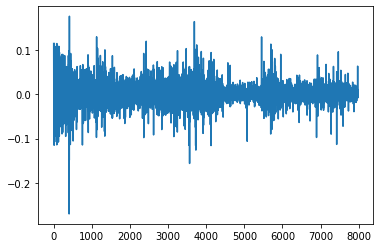

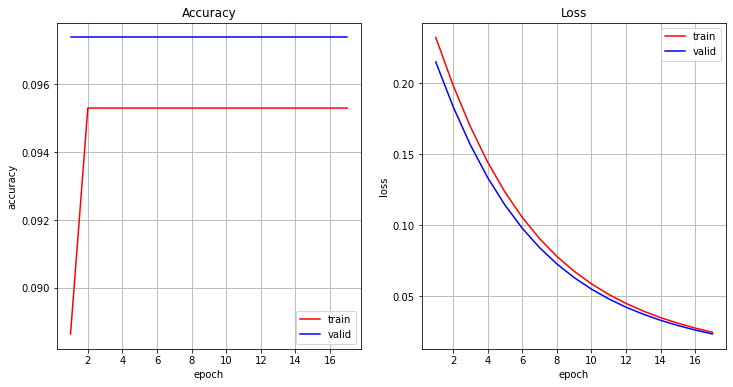

Evaluamos el modelo en train_score: [0.0234824288636446, 0.09550561755895615]
167/167 [==============================] - 0s 1ms/step
Predecimos con los datos de train: 0.15158069205198957
Predecimos con los datos de train_cantidad/dimensiones de datos:(5340, 1)
 La media de error en la prediccion en entrenamiento es: 0.014863497953216202
83/83 [==============================] - 0s 1ms/step
 El  error de la predicion usando datos de test es de : 0.15085412520337338
 La media de error en la prediccion en test es: 0.015448941272222535
Mostramos las predicciones de entrenamiento en primera fila y de test en segunda fila:
83/83 [==============================] - 0s 1ms/step
17
(17, 54)


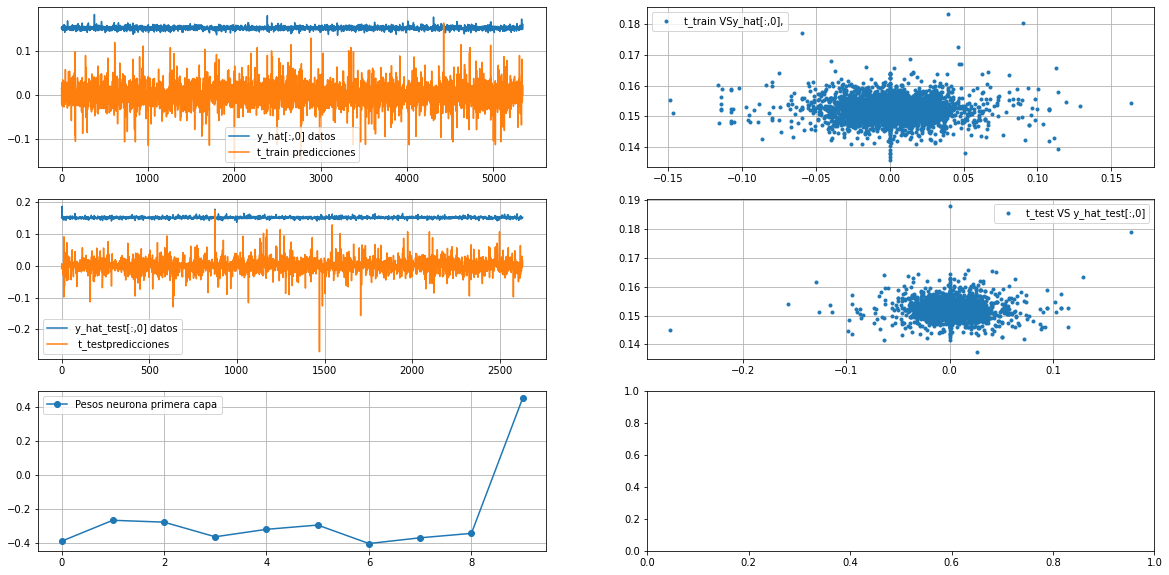

In [13]:
# CASO_1
DAT_1 = sacar_open_Microsoft_normalizado_y_con_numero_de_valores ()
x_train, x_test, t_train, t_test = Reordeno_dataset_en_bloques_LAG_dias_y_siguiente_dia_predice_y_split(LAG = 11,DAT_1 = DAT_1)
model, hist = activo_caso_1(x_train, x_test, t_train, t_test)
model_title = 'EJ_3_CASO_1_LINEAL_TONTO_CON_REG.LOG.'
salida, df = datos_para_comparar_modelos (x_train, t_train, x_test, t_test, model)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.4 MB/s eta 0:00:00
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 10)             40        
                                                                 
 conv1d_1 (Conv1D)           (None, 6, 10)             310       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 10)            0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 1)              31        
                                                                 
Total params: 381
Trainable params: 381
Non-trainable params: 0
____________________________

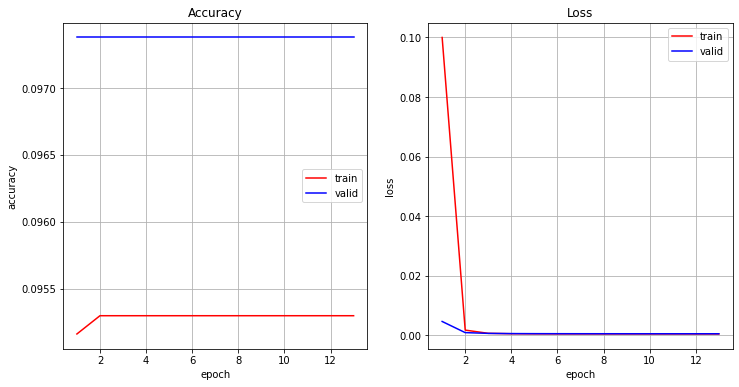

Evaluamos el modelo en train_score: [0.0004993073525838554, 0.09550561755895615]
167/167 [==============================] - 0s 2ms/step
Predecimos con los datos de train: 0.015158686990589901
Predecimos con los datos de train_cantidad/dimensiones de datos:(5340, 1, 1)
 La media de error en la prediccion en entrenamiento es: 0.014863497953216202
83/83 [==============================] - 0s 3ms/step
 El  error de la predicion usando datos de test es de : 0.015611412491241419
 La media de error en la prediccion en test es: 0.015448941272222535
Mostramos las predicciones de entrenamiento en primera fila y de test en segunda fila:
83/83 [==============================] - 0s 2ms/step
17
(17, 54)


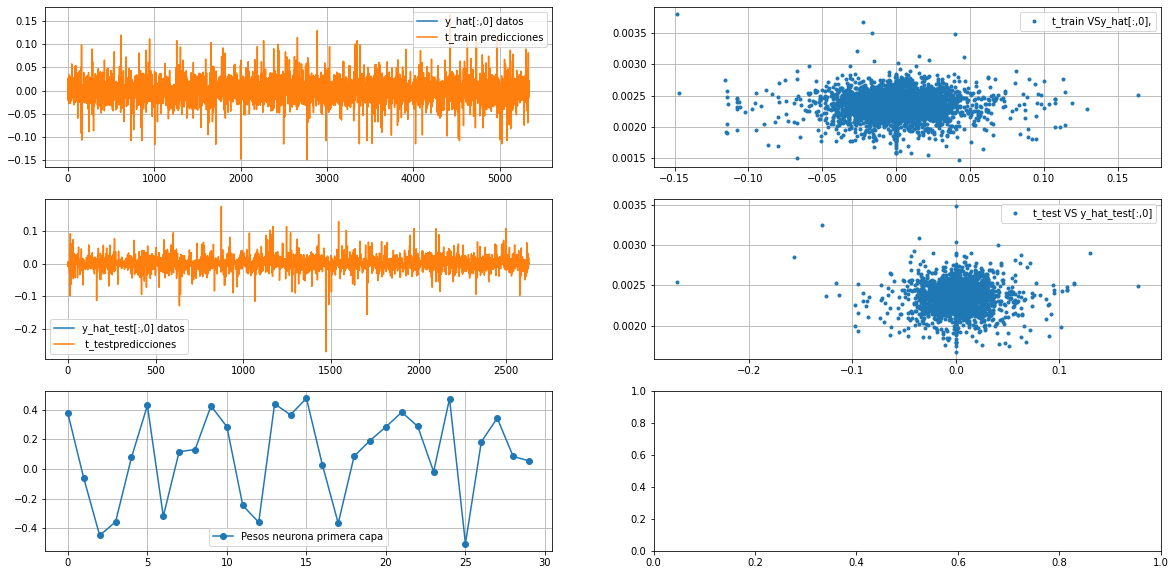

In [14]:
# CASO_2
model, hist = activo_caso_2(x_train, x_test, t_train, t_test)
model_title = 'EJ_3_CASO_2_Conv1D(10,3,.Conv1D(10,3.MaxPooling1D.Conv1D(1,3_CON_REG.LOG.'
salida, df = datos_para_comparar_modelos (x_train, t_train, x_test, t_test, model)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 10, 10)            40        
                                                                 
 conv1d_4 (Conv1D)           (None, 10, 10)            310       
                                                                 
 flatten_1 (Flatten)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 451
Trainable params: 451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
151/151 [==============================] - 2s 5ms/step - loss: 0.0743 - accuracy: 0.0945 - val_loss: 0.0013 - val_accuracy: 0.0974
Epoch 2/100
151/151 [========================

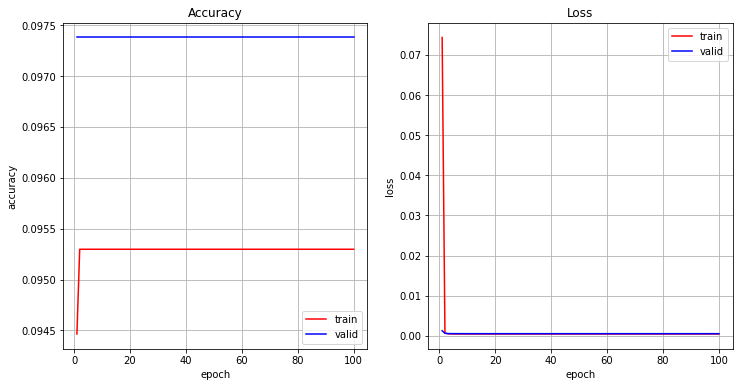

Evaluamos el modelo en train_score: [0.0004956863122060895, 0.09550561755895615]
167/167 [==============================] - 0s 2ms/step
Predecimos con los datos de train: 0.01491068662905953
Predecimos con los datos de train_cantidad/dimensiones de datos:(5340, 1)
 La media de error en la prediccion en entrenamiento es: 0.014863497953216202
83/83 [==============================] - 0s 2ms/step
 El  error de la predicion usando datos de test es de : 0.015459060809680654
 La media de error en la prediccion en test es: 0.015448941272222535
Mostramos las predicciones de entrenamiento en primera fila y de test en segunda fila:
83/83 [==============================] - 0s 2ms/step
17
(17, 54)


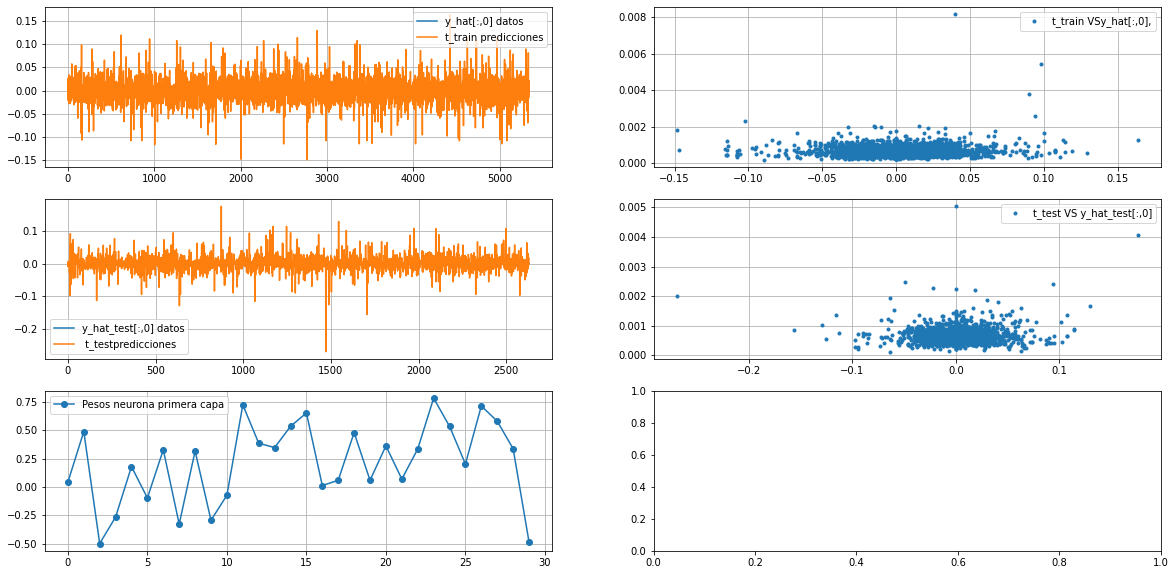

In [15]:
# CASO_3
model, hist = activo_caso_3(x_train, x_test, t_train, t_test)
model_title = 'EJ_3_CASO_3_Conv1D(10,3,.Conv1D(10,3.Flatten.Dense(1_CON_REG.LOG.'
salida, df = datos_para_comparar_modelos (x_train, t_train, x_test, t_test, model)

In [16]:
# CONCLUSION. PARECE QUE PONIENDO EL RETORNO EN VEZ DEL PRECIO NORMALIZADO,
# PARA REDES CONVOLUCIONALES, NO VA PQ LOS DATOS SON TOTALMENTE DESCORRELADOS

In [17]:
###############################################################################################################################

In [18]:
# AHORA REPITO TODO PERO SIN HACER EL RETORNO LOGARITMICO DE LOS PRECIOS PERO SI NORMALIZANDO COMO VALERO
# HIZO EN CLASE
# valor_a_normalizar = DAT.max()
# DAT = DAT/ valor_a_normalizar

(7983,)
(7983, 1)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


<ipython-input-7-5f3362fdec50>:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_x = DAT_TS[range(0,np.int(Ntr)),0:LAG-1,:]
<ipython-input-7-5f3362fdec50>:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumP

151/151 [==============================] - 1s 4ms/step - loss: 0.1098 - accuracy: 2.0807e-04 - val_loss: 0.0986 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
151/151 [==============================] - 1s 4ms/step - loss: 0.0867 - accuracy: 0.0000e+00 - val_loss: 0.0849 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
151/151 [==============================] - 1s 6ms/step - loss: 0.0757 - accuracy: 0.0000e+00 - val_loss: 0.0751 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
151/151 [==============================] - 1s 4ms/step - loss: 0.0668 - accuracy: 0.0000e+00 - val_loss: 0.0660 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
151/151 [==============================] - 1s 5ms/step - loss: 0.0585 - accuracy: 0.0000e+00 - val_loss: 0.0577 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/100
151/151 [==============================] - 0s 3ms/step - loss: 0.0510 - accuracy: 0.0000e+00 - val_loss: 0.0501 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 7/100
151/151 [=======

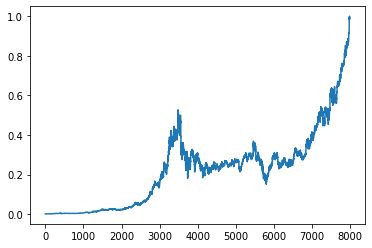

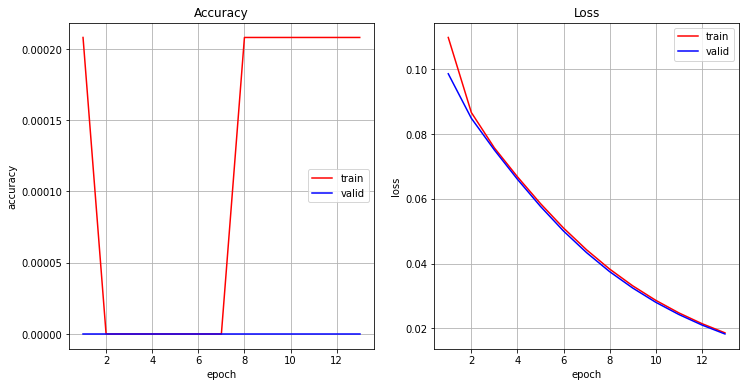

Evaluamos el modelo en train_score: [0.017405252903699875, 0.00018723084940575063]
167/167 [==============================] - 1s 4ms/step
Predecimos con los datos de train: 0.11070426547893104
Predecimos con los datos de train_cantidad/dimensiones de datos:(5341, 1)
 La media de error en la prediccion en entrenamiento es: 0.22105163121100596
83/83 [==============================] - 0s 5ms/step
 El  error de la predicion usando datos de test es de : 0.10950011929079685
 La media de error en la prediccion en test es: 0.23016269497892813
Mostramos las predicciones de entrenamiento en primera fila y de test en segunda fila:
83/83 [==============================] - 0s 3ms/step
17
(17, 54)


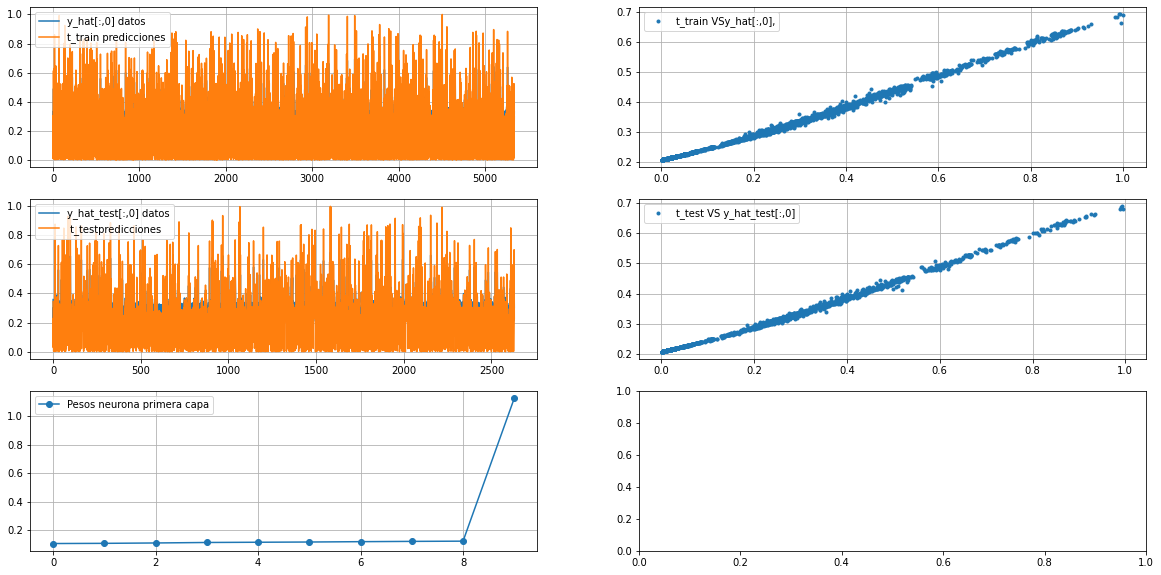

In [19]:
# CASO_1
DAT_1 = sacar_open_Microsoft_normalizado_y_con_numero_de_valores_SIN_RETORNO_LOG ()
x_train, x_test, t_train, t_test = Reordeno_dataset_en_bloques_LAG_dias_y_siguiente_dia_predice_y_split(LAG = 11,DAT_1 = DAT_1)
model, hist = activo_caso_1(x_train, x_test, t_train, t_test)
model_title = 'EJ_3_CASO_1_LINEAL_TONTO_normalizado_SIN_REG.LOG.'
salida, df = datos_para_comparar_modelos (x_train, t_train, x_test, t_test, model)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 8, 10)             40        
                                                                 
 conv1d_6 (Conv1D)           (None, 6, 10)             310       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3, 10)            0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 1, 1)              31        
                                                                 
Total params: 381
Trainable params: 381
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
151/151 [==============================] - 3s 8ms/step - loss: 0.0745 - accuracy: 0.0000e+00 - val_loss: 0.043

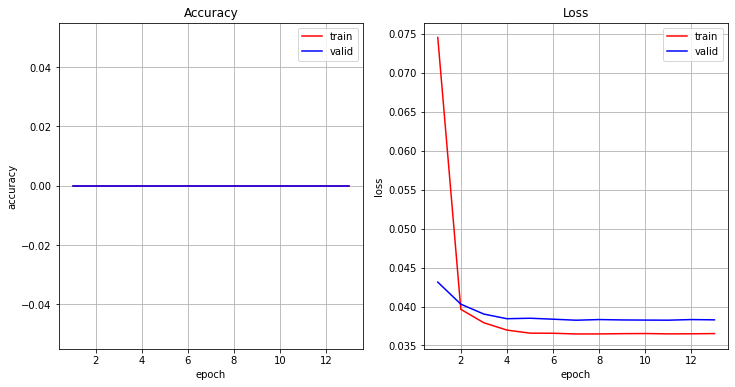

Evaluamos el modelo en train_score: [0.03677919879555702, 0.0]
167/167 [==============================] - 0s 2ms/step
Predecimos con los datos de train: 0.14950389353185192
Predecimos con los datos de train_cantidad/dimensiones de datos:(5341, 1, 1)
 La media de error en la prediccion en entrenamiento es: 0.22105163121100596
83/83 [==============================] - 0s 3ms/step
 El  error de la predicion usando datos de test es de : 0.15170180023346994
 La media de error en la prediccion en test es: 0.23016269497892813
Mostramos las predicciones de entrenamiento en primera fila y de test en segunda fila:
83/83 [==============================] - 0s 2ms/step
17
(17, 54)


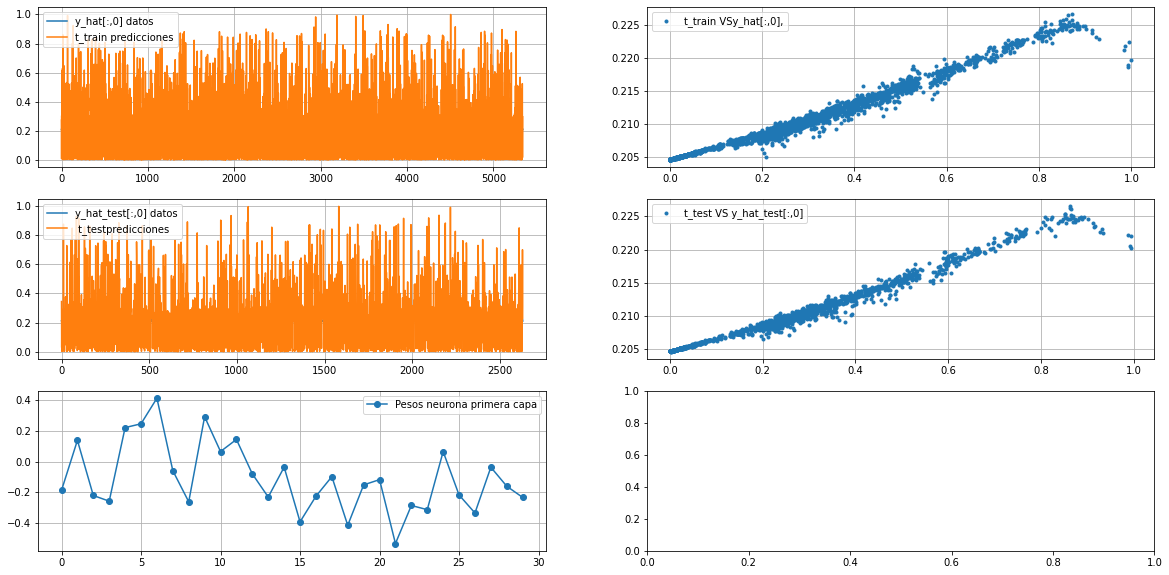

In [20]:
# CASO_2
model, hist = activo_caso_2(x_train, x_test, t_train, t_test)
model_title = 'EJ_3_CASO_2_Conv1D(10,3,.Conv1D(10,3.MaxPooling1D.Conv1D(1,3_normalizado_SIN_REG.LOG.'
salida, df = datos_para_comparar_modelos (x_train, t_train, x_test, t_test, model)

In [ ]:
# CASO_3
model, hist = activo_caso_3(x_train, x_test, t_train, t_test)
model_title = 'EJ_3_CASO_3_Conv1D(10,3,.Conv1D(10,3.Flatten.Dense(1_normalizado_SIN_REG.LOG.'
salida, df = datos_para_comparar_modelos (x_train, t_train, x_test, t_test, model)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 10, 10)            40        
                                                                 
 conv1d_9 (Conv1D)           (None, 10, 10)            310       
                                                                 
 flatten_3 (Flatten)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 451
Trainable params: 451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
151/151 [==============================] - 2s 6ms/step - loss: 0.0511 - accuracy: 0.0000e+00 - val_loss: 0.0024 - val_accuracy: 0.0000e+00
Epoch 2/100
151/151 [================

In [ ]:
# casi todos modelos creados son mejores que " el lineal tonto" considrando que solo veo
# el loss mas bajo en train y test con respecto al "el lineal tonto"


# valores mirando solo el loss de test y train como se hacia en clase:
# 'EJ_3_CASO_1_LINEAL_TONTO_CON_REG.LOG.'
# SCORE DE TRAIN: [0.023484662175178528, 0.09550561755895615]
# SCORE DE TEST: [0.023326978087425232, 0.08551881462335587]

# 'EJ_3_CASO_2_Conv1D(10,3,.Conv1D(10,3.MaxPooling1D.Conv1D(1,3_CON_REG.LOG.'
# SCORE DE TRAIN: [0.0005020375247113407, 0.09550561755895615]
# SCORE DE TEST: [0.0005627037608064711, 0.08551881462335587]

# 'EJ_3_CASO_3_Conv1D(10,3,.Conv1D(10,3.Flatten.Dense(1_CON_REG.LOG.'
# SCORE DE TRAIN:[0.000494942010845989, 0.09550561755895615]
# SCORE DE TEST: [0.0005598939605988562, 0.08551881462335587]

# 'EJ_3_CASO_1_LINEAL_TONTO_normalizado_SIN_REG.LOG.'
# SCORE DE TRAIN: [0.017413152381777763, 0.00018723084940575063]
# SCORE DE TEST:[0.017069626599550247, 0.0]
# este habia bajado mas si se le hubiera subido las epocas. 
# Pero para este hercicio entiendo que vale.

# 'EJ_3_CASO_2_Conv1D(10,3,.Conv1D(10,3.MaxPooling1D.Conv1D(1,3_normalizado_SIN_REG.LOG.'
# SCORE DE TRAIN: [0.036640606820583344, 0.0]
# SCORE DE TEST: [0.03894549235701561, 0.0]

# 'EJ_3_CASO_3_Conv1D(10,3,.Conv1D(10,3.Flatten.Dense(1_normalizado_SIN_REG.LOG.'
# SCORE DE TRAIN: [6.227159610716626e-05, 0.00018723084940575063]
# SCORE DE TEST: [7.339258445426822e-05, 0.0]

In [ ]:
# No he hecho hiperparametros ni he optimizado lr ni epocas, etc 
# pq entiendo que para este ejercicio no se requeria. Lo mismo me sucede para los 
# siguientes ejercicios.